In [ ]:
import json
import numpy as np
import tensorflow as tf
import pandas as pd
import re
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Conv1D, MaxPooling1D
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from JSON files
with open('uw_n_positive.json') as f:
    pos_data = json.load(f)
with open('merged_negative.json') as f:
    neg_data = json.load(f)
with open('uwm_negative.json') as f:
    neg_data1 = json.load(f)

# Combine positive and negative data into one dataframe
pos_df = pd.DataFrame(pos_data)
pos_df['sentiment'] = 1
neg_df = pd.DataFrame(neg_data).append(pd.DataFrame(neg_data1))
neg_df['sentiment'] = 0
df = pd.concat([pos_df, neg_df], ignore_index=True)

<ipython-input-2-c6d736da2b19>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_df = pd.DataFrame(neg_data).append(pd.DataFrame(neg_data1))


In [ ]:
def preprocess_text(text):
  # Convert to lowercase
  text = text.lower()
  # Remove URLs
  text = re.sub(r'http\S+', '', text)

  # Remove non-alphanumeric characters
  text = re.sub(r'[^a-z0-9\s]', '', text)

  # Remove stopwords
  nltk.download('stopwords')
  stop_words = set(stopwords.words('english'))
  text = ' '.join(word for word in text.split() if word not in stop_words)

  return text

df['text'] = df['text'].apply(preprocess_text)


Streaming output truncated to the last 5000 lines.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-dat

In [ ]:
# Initialize CountVectorizer object
count_vectorizer = CountVectorizer()

# Fit and transform the 'text' column of the dataframe using CountVectorizer
# This converts the text into a sparse matrix of token counts
bag_of_words = count_vectorizer.fit_transform(df['text'])

In [ ]:
# Create an instance of the TfidfVectorizer class
tfidf_vectorizer = TfidfVectorizer()

# Use the fit_transform method to compute the IDF values for the words in the corpus
# and generate a TF-IDF matrix for the text data
tfidf = tfidf_vectorizer.fit_transform(df['text'])

In [ ]:
# Initialize a tokenizer object with a maximum of 5000 words and all text converted to lowercase
tokenizer = Tokenizer(num_words=5000, lower=True)

# Fit the tokenizer on the text data in the 'text' column of the dataframe
tokenizer.fit_on_texts(df['text'])

# Convert the text data in the 'text' column of the dataframe into sequences of integers using the fitted tokenizer
X = tokenizer.texts_to_sequences(df['text'])

# Pad the sequences to a maximum length of 100
X = pad_sequences(X, maxlen=100)


In [ ]:
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Embedding(5000, 64, input_length=X.shape[1]))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(100, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
optimizer = Adam(lr=0.00009, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1,callbacks=[earlystop])

Epoch 1/20
105/105 [==============================] - 17s 113ms/step - loss: 0.6851 - accuracy: 0.5545 - val_loss: 0.6837 - val_accuracy: 0.5297
Epoch 2/20
105/105 [==============================] - 10s 92ms/step - loss: 0.6472 - accuracy: 0.6026 - val_loss: 0.6012 - val_accuracy: 0.6541
Epoch 3/20
105/105 [==============================] - 11s 101ms/step - loss: 0.4402 - accuracy: 0.8047 - val_loss: 0.3752 - val_accuracy: 0.8135
Epoch 4/20
105/105 [==============================] - 11s 103ms/step - loss: 0.2513 - accuracy: 0.9063 - val_loss: 0.3367 - val_accuracy: 0.8297
Epoch 5/20
105/105 [==============================] - 11s 102ms/step - loss: 0.1692 - accuracy: 0.9390 - val_loss: 0.3514 - val_accuracy: 0.8270
Epoch 6/20
105/105 [==============================] - 11s 102ms/step - loss: 0.1161 - accuracy: 0.9597 - val_loss: 0.3539 - val_accuracy: 0.8216
Epoch 7/20
105/105 [==============================] - 9s 90ms/step - loss: 0.0843 - accuracy: 0.9736 - val_loss: 0.4031 - val_accur

29/29 [==============================] - 2s 23ms/step
Accuracy: 0.8648648648648649
Precision: 0.88268156424581
Recall: 0.8843283582089553
F1-score: 0.8835041938490215


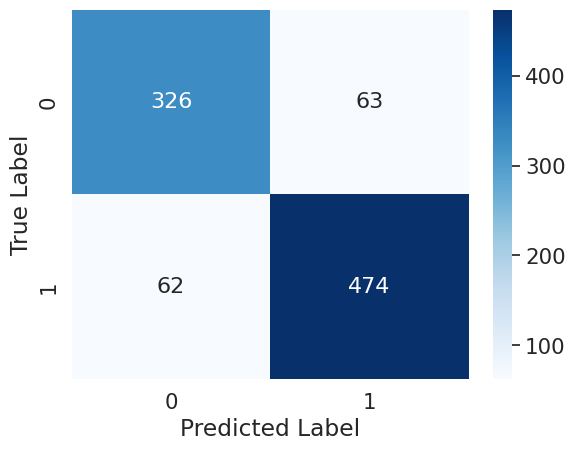

In [ ]:
y_pred = model.predict(X_test)
y_pred = [1 if x>=0.5 else 0 for x in y_pred]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

sns.set(font_scale=1.4)
sns.heatmap(confusion_mat, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Define a function for sentiment prediction
def predict_sentiment(text):
    # Preprocess input text
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuations
    text = text.lower()  # convert text to lowercase
    text = [text]  # convert text to list

    # Tokenize and pad input text
    text_seq = tokenizer.texts_to_sequences(text)
    text_seq = pad_sequences(text_seq, maxlen=100)

    # Make prediction using the trained model
    pred = model.predict(text_seq)
    pred = 1 if pred[0] >= 0.5 else 0

    # Return predicted sentiment
    return 'Positive' if pred == 1 else 'Negative'

# Test the model on 10 sample sentences
sentences = ['I love this movie!', 
             'This is the worst product I have ever bought.', 
             'The food was amazing at the restaurant.',
             'I hate waking up early in the morning.',
             'The customer service was terrible.',
             'I had a great time at the party.',
             'The traffic was so bad this morning.',
             'The book was very interesting.',
             'I had a terrible experience at the hotel.',
             'The weather was perfect for a picnic.']

for sentence in sentences:
    print(f'Sentence: {sentence} \nPredicted Sentiment: {predict_sentiment(sentence)}\n')


1/1 [==============================] - 0s 28ms/step
Sentence: I love this movie! 
Predicted Sentiment: Positive

1/1 [==============================] - 0s 34ms/step
Sentence: This is the worst product I have ever bought. 
Predicted Sentiment: Negative

1/1 [==============================] - 0s 30ms/step
Sentence: The food was amazing at the restaurant. 
Predicted Sentiment: Positive

1/1 [==============================] - 0s 42ms/step
Sentence: I hate waking up early in the morning. 
Predicted Sentiment: Negative

1/1 [==============================] - 0s 29ms/step
Sentence: The customer service was terrible. 
Predicted Sentiment: Negative

1/1 [==============================] - 0s 37ms/step
Sentence: I had a great time at the party. 
Predicted Sentiment: Positive

1/1 [==============================] - 0s 26ms/step
Sentence: The traffic was so bad this morning. 
Predicted Sentiment: Negative

1/1 [==============================] - 0s 45ms/step
Sentence: The book was very interesting. 